In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from scipy.stats import shapiro
from arch import arch_model

In [2]:
train_data = pd.read_csv('/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Data/train_data_HDD.csv')
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)
train_data = train_data.resample('D').asfreq().fillna(method='ffill')
train_data = train_data[train_data.index >= '2020-01-01']

In [3]:
#Creating Differences for ADF test

train_data["Temp. First Difference"] = train_data["mean"] - train_data["mean"].shift(1)
train_data["Seasonal Difference"] = train_data["mean"] - train_data["mean"].shift(365)
train_data["Seasonal First Difference"] = train_data["Temp. First Difference"] - train_data[
    "Temp. First Difference"
].shift(365)

In [4]:
def adf_check(series):
    
        results = adfuller(series, autolag='AIC')
        print()
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        print("Augmented Dickey-Fuller Unit Root Test:")
        labels = [
            "ADF Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ]
        
        for value, label in zip(results, labels):
            print(f"{label} : {value}")
            
        if results[1] <= 0.05:
            print("Reject the null hypothesis: Series is stationary and has no unit root")
        else:
            print("Weak evidence against the null hypothesis: Series is non-stationary and has a unit root")
            
        print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
        

adf_check(train_data['mean'])

adf_check(train_data["Seasonal Difference"].dropna())


adf_check(train_data["Seasonal First Difference"].dropna())
    


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -2.587377543471065
p-value : 0.0956342364226167
#Lags Used : 12
Number of Observations Used : 1630
Weak evidence against the null hypothesis: Series is non-stationary and has a unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -4.755924155275461
p-value : 6.598886712611378e-05
#Lags Used : 23
Number of Observations Used : 1254
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Augmented Dickey-Fuller Unit Root Test:
ADF Test Statistic : -10.667664634048434
p-value : 4.2460943901293497e-19
#Lags Used : 23
Number of Observations Used : 1253
Reject the null hypothesis: Series is stationary and has no unit root
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [10]:
import numpy as np
import psutil
import os
import gc
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

def log_memory(tag=""):
    process = psutil.Process(os.getpid())
    mem_mb = process.memory_info().rss / (1024 ** 2)
    print(f"[MEMORY] {tag} - Memory usage: {mem_mb:.2f} MB")

def best_sarima_model(train_data, p_values, q_values, P_values, Q_values, s=365):
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None
    best_params = None
    model_results = []

    tried_configs = set()
    param_cache = {}

    best_model_path = "best_model.pkl"

    for p in p_values:
        for q in q_values:
            for P in P_values:
                for Q in Q_values:
                    config = ((p, 1, q), (P, 1, Q, s))
                    if config in tried_configs:
                        continue
                    tried_configs.add(config)

                    try:
                        print(f"\nTrying SARIMA{config}")
                        log_memory("Before fit")

                        start_params = param_cache.get((p, q, P, Q), None)

                        model = SARIMAX(
                            train_data,
                            order=(p, 1, q),
                            seasonal_order=(P, 1, Q, s),
                            trend='c',
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                            simple_differencing=True
                        )

                        if start_params is not None and len(start_params) == model.k_params:
                            fitted_model = model.fit(
                                disp=False,
                                start_params=start_params,
                                maxiter=50,
                                cov_type="none"
                            )
                        else:
                            fitted_model = model.fit(
                                disp=False,
                                maxiter=50,
                                cov_type="none"
                            )

                        log_memory("After fit")

                        aic = fitted_model.aic
                        model_results.append((config, aic))
                        print(f"Finished SARIMA{config} - AIC: {aic:.2f}")

                        current_params = np.copy(fitted_model.params)
                        param_cache[(p, q, P, Q)] = current_params

                        if aic < best_aic:
                            best_aic = aic
                            best_order, best_seasonal_order = config
                            best_params = current_params
                            print(f"New best model: SARIMA{config} - AIC: {aic:.2f}")

                            # Save best model to disk
                            fitted_model.save(best_model_path)

                        # Clean up aggressively
                        del fitted_model
                        del model
                        gc.collect()

                    except MemoryError:
                        print(f"MemoryError on SARIMA{config}")
                        continue
                    except Exception as e:
                        print(f"Failed SARIMA{config}: {e}")
                        continue

    if best_order is not None:
        print("\nReloading best model from disk...")
        best_model = SARIMAXResults.load(best_model_path)
        print(f"Best Model Based on AIC: SARIMA{(best_order, best_seasonal_order)} - AIC: {best_aic:.2f}")
        return best_model, model_results
    else:
        print("No SARIMA model successfully fitted.")
        return None, model_results



best_model, results = best_sarima_model(
    train_data['mean'],
    p_values=[0, 1, 2, 3],
    q_values=[0, 1],
    P_values=[0, 1],
    Q_values=[0, 1]
)


Trying SARIMA((0, 1, 0), (0, 1, 0, 365))
[MEMORY] Before fit - Memory usage: 188.07 MB
[MEMORY] After fit - Memory usage: 188.43 MB
Finished SARIMA((0, 1, 0), (0, 1, 0, 365)) - AIC: 7194.81
New best model: SARIMA((0, 1, 0), (0, 1, 0, 365)) - AIC: 7194.81

Trying SARIMA((0, 1, 0), (0, 1, 1, 365))
[MEMORY] Before fit - Memory usage: 187.95 MB
[MEMORY] After fit - Memory usage: 3706.32 MB
Finished SARIMA((0, 1, 0), (0, 1, 1, 365)) - AIC: 5044.97
New best model: SARIMA((0, 1, 0), (0, 1, 1, 365)) - AIC: 5044.97

Trying SARIMA((0, 1, 0), (1, 1, 0, 365))
[MEMORY] Before fit - Memory usage: 146.14 MB
[MEMORY] After fit - Memory usage: 3820.06 MB
Finished SARIMA((0, 1, 0), (1, 1, 0, 365)) - AIC: 4942.85
New best model: SARIMA((0, 1, 0), (1, 1, 0, 365)) - AIC: 4942.85

Trying SARIMA((0, 1, 0), (1, 1, 1, 365))
[MEMORY] Before fit - Memory usage: 146.16 MB
[MEMORY] After fit - Memory usage: 3490.87 MB
Finished SARIMA((0, 1, 0), (1, 1, 1, 365)) - AIC: 4896.22
New best model: SARIMA((0, 1, 0), (1, 

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[MEMORY] After fit - Memory usage: 146.75 MB
Finished SARIMA((1, 1, 1), (0, 1, 0, 365)) - AIC: 7031.18

Trying SARIMA((1, 1, 1), (0, 1, 1, 365))
[MEMORY] Before fit - Memory usage: 146.55 MB
[MEMORY] After fit - Memory usage: 922.81 MB
Finished SARIMA((1, 1, 1), (0, 1, 1, 365)) - AIC: 5020.65

Trying SARIMA((1, 1, 1), (1, 1, 0, 365))
[MEMORY] Before fit - Memory usage: 143.96 MB
[MEMORY] After fit - Memory usage: 1178.71 MB
Finished SARIMA((1, 1, 1), (1, 1, 0, 365)) - AIC: 4908.67

Trying SARIMA((1, 1, 1), (1, 1, 1, 365))
[MEMORY] Before fit - Memory usage: 143.75 MB
[MEMORY] After fit - Memory usage: 847.52 MB
Finished SARIMA((1, 1, 1), (1, 1, 1, 365)) - AIC: 4862.39
New best model: SARIMA((1, 1, 1), (1, 1, 1, 365)) - AIC: 4862.39

Trying SARIMA((2, 1, 0), (0, 1, 0, 365))
[MEMORY] Before fit - Memory usage: 140.30 MB
[MEMORY] After fit - Memory usage: 146.05 MB
Finished SARIMA((2, 1, 0), (0, 1, 0, 365)) - AIC: 7144.29

Trying SARIMA((2, 1, 0), (0, 1, 1, 365))
[MEMORY] Before fit - Mem

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


[MEMORY] After fit - Memory usage: 371.22 MB
Finished SARIMA((3, 1, 1), (1, 1, 1, 365)) - AIC: 4700.94
New best model: SARIMA((3, 1, 1), (1, 1, 1, 365)) - AIC: 4700.94

Reloading best model from disk...
Best Model Based on AIC: SARIMA((3, 1, 1), (1, 1, 1, 365)) - AIC: 4700.94


In [17]:
Models = pd.DataFrame(results, columns=["Model", "AIC"])
# Find the best 5 models
Models = Models.sort_values(by="AIC")
Models

,Model,AIC
31,"((3, 1, 1), (1, 1, 1, 365))",4700.937281
23,"((2, 1, 1), (1, 1, 1, 365))",4707.277120
30,"((3, 1, 1), (1, 1, 0, 365))",4742.360613
22,"((2, 1, 1), (1, 1, 0, 365))",4748.208419
27,"((3, 1, 0), (1, 1, 1, 365))",4815.135714
19,"((2, 1, 0), (1, 1, 1, 365))",4848.748526
26,"((3, 1, 0), (1, 1, 0, 365))",4856.760774
15,"((1, 1, 1), (1, 1, 1, 365))",4862.389880
7,"((0, 1, 1), (1, 1, 1, 365))",4862.611994
21,"((2, 1, 1), (0, 1, 1, 365))",4869.093590


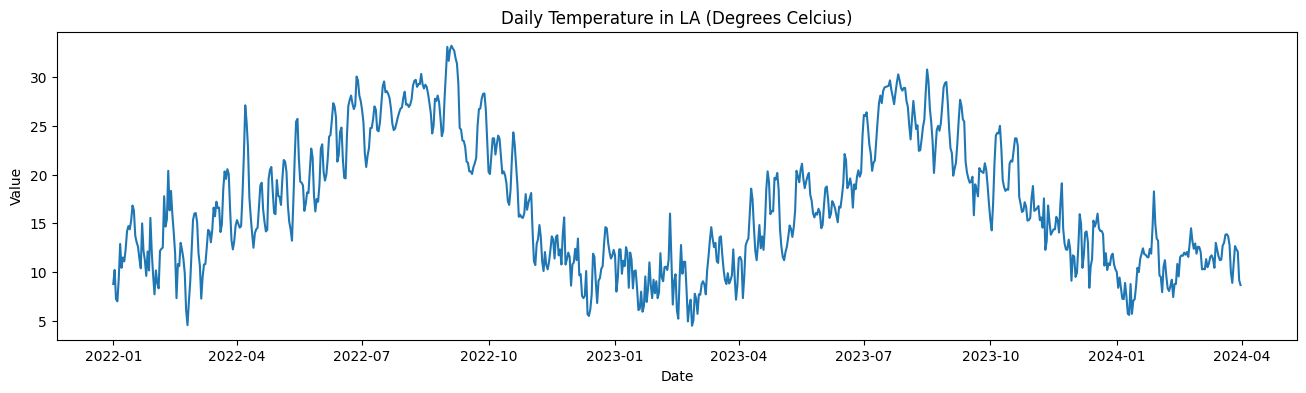

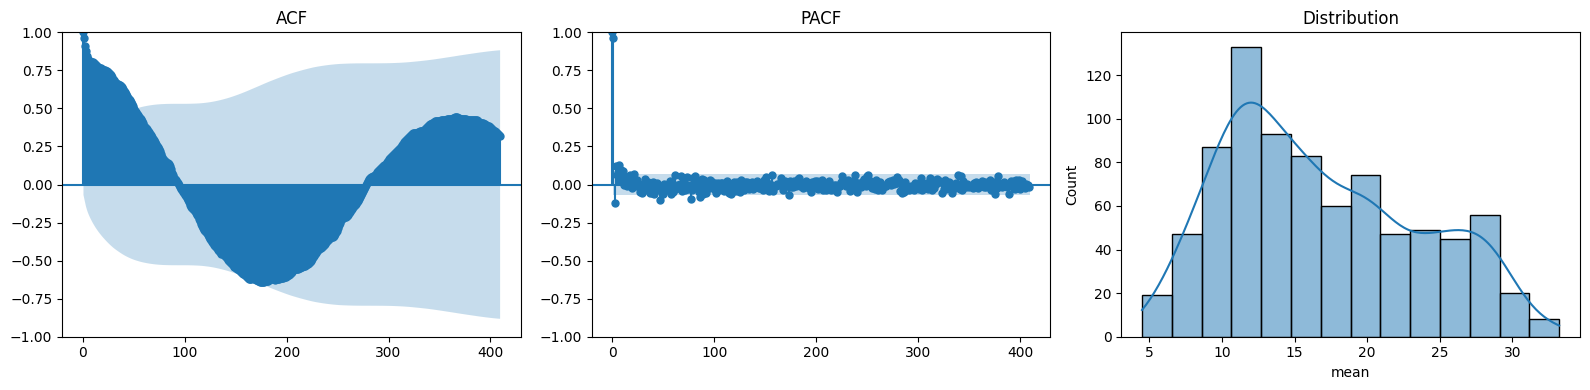

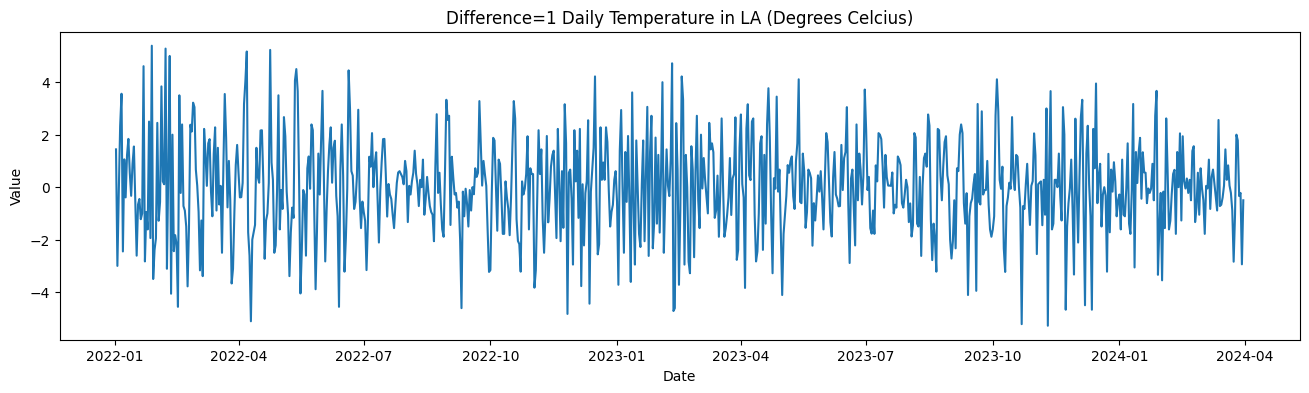

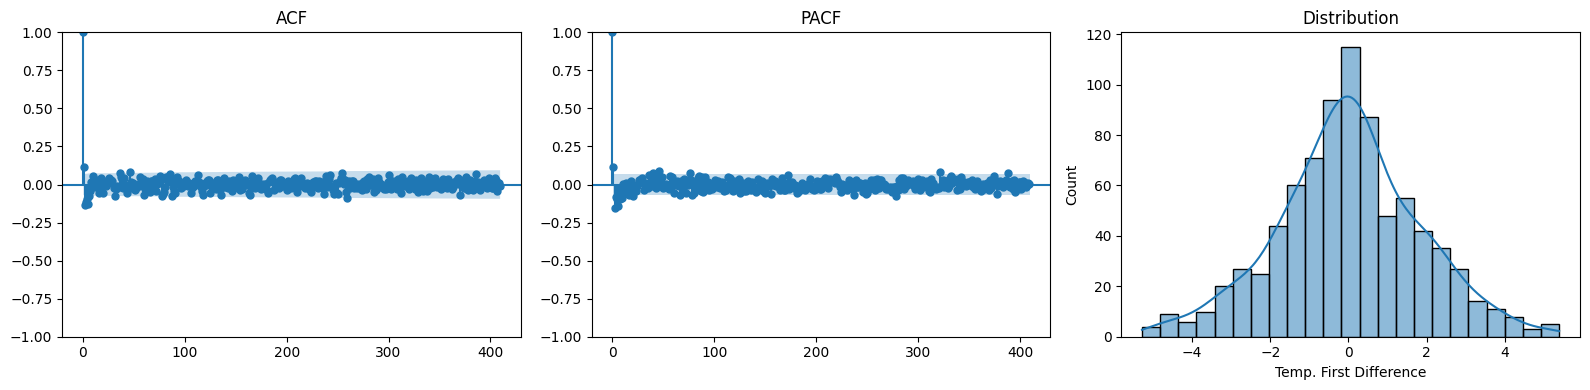

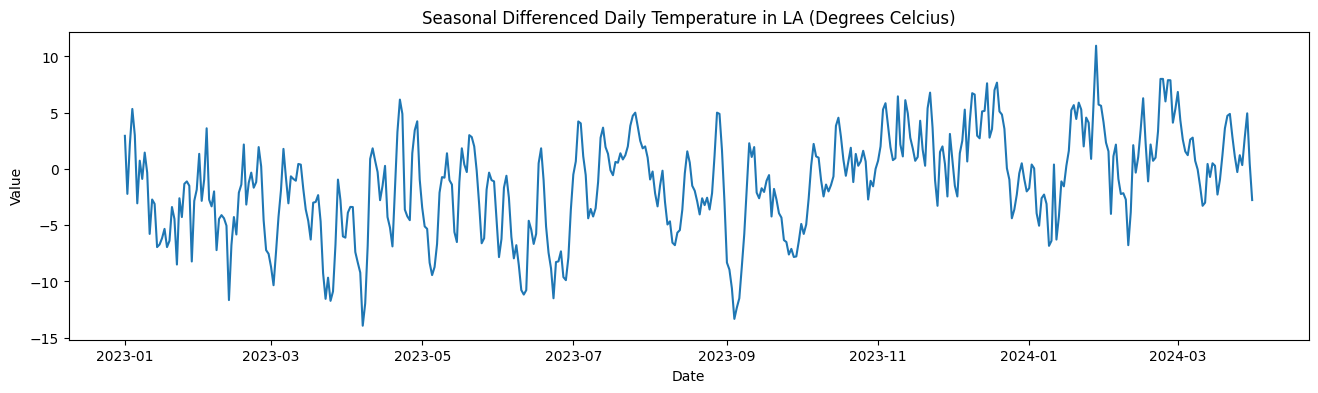

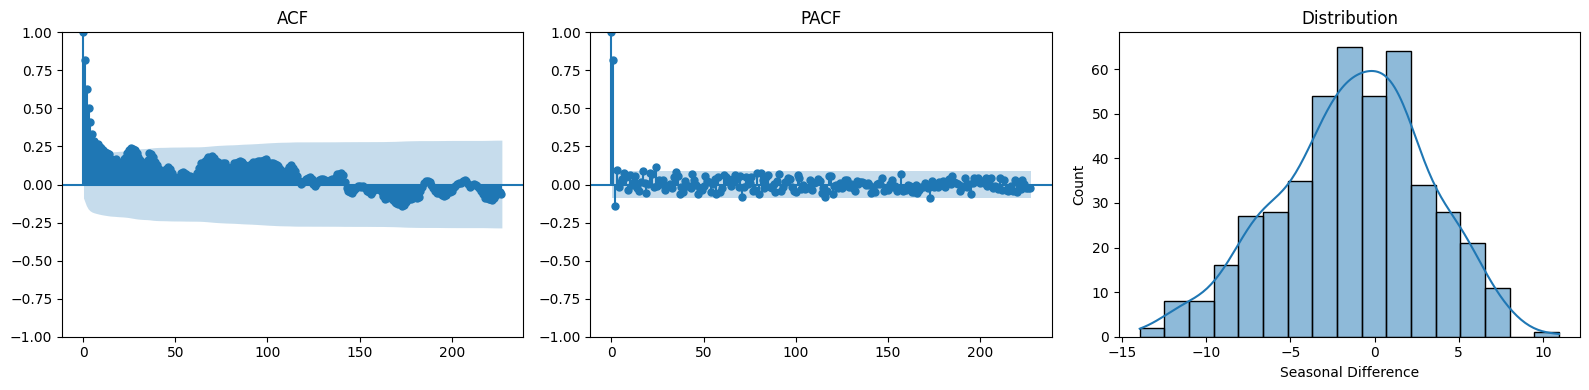

In [5]:
def plot_data_properties(data, ts_plot_name="Time Series plot"):
    data = data.dropna()

    plt.figure(figsize=(16,4))
    plt.plot(data)
    plt.title(ts_plot_name)
    plt.ylabel('Value')
    plt.xlabel('Date')

    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plot_acf(data, ax=axes[0], lags=min(4000, len(data)//2 - 1))
    axes[0].set_title("ACF")

    plot_pacf(data, ax=axes[1], lags=min(4000, len(data)//2 - 1), method='ywm')
    axes[1].set_title("PACF")

    sns.histplot(data, ax=axes[2], kde=True)
    axes[2].set_title("Distribution")

    plt.tight_layout()
    plt.show()

    
    
plot_data_properties(train_data['mean'], 'Daily Temperature in LA (Degrees Celcius)')

plot_data_properties(train_data['Temp. First Difference'], 'Difference=1 Daily Temperature in LA (Degrees Celcius)')

plot_data_properties(train_data['Seasonal Difference'], 'Seasonal Differenced Daily Temperature in LA (Degrees Celcius)')


In [5]:
model = SARIMAX(
    train_data["mean"],
    order=(3, 1, 1),
    seasonal_order=(1, 1, 1, 365), 
    trend='c',
    enforce_stationarity=True,
    enforce_invertibility=True,
    simple_differencing=False)

results = model.fit(maxiter=100)
print(results.summary())

results.save("sarima_model_results.pkl")

/opt/anaconda3/envs/weather_deriv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82715D+00    |proj g|=  7.14927D-02


 This problem is unconstrained.



At iterate    5    f=  1.78455D+00    |proj g|=  2.16656D-02

At iterate   10    f=  1.75904D+00    |proj g|=  5.32418D-02

At iterate   15    f=  1.74482D+00    |proj g|=  2.15005D-01

At iterate   20    f=  1.73945D+00    |proj g|=  1.27409D-01

At iterate   25    f=  1.73889D+00    |proj g|=  6.04244D-02

At iterate   30    f=  1.73760D+00    |proj g|=  4.86008D-01

At iterate   35    f=  1.73742D+00    |proj g|=  6.11353D-02

At iterate   40    f=  1.73742D+00    |proj g|=  3.02604D-02

At iterate   45    f=  1.73741D+00    |proj g|=  7.08441D-02

At iterate   50    f=  1.73741D+00    |proj g|=  1.98911D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

: 

In [22]:
from statsmodels.tsa.statespace.sarimax import SARIMAXResults
results = SARIMAXResults.load("sarima_model_results.pkl")
# Now you can use it to make predictions
forecast = results.forecast(steps=30)
print(forecast)

: 

In [7]:
resid = results.resid

# turn to a df
resid = pd.DataFrame(resid)

# Remove the first 365 rows
#resid = resid.iloc[365:]

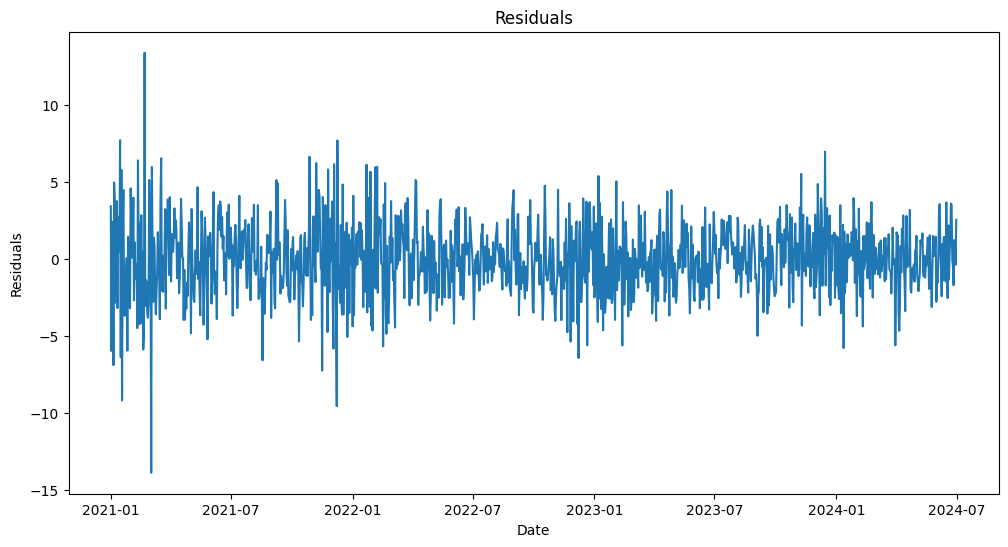

<Axes: title={'center': 'Residuals Kernel Density Function'}, xlabel='Date', ylabel='Density'>

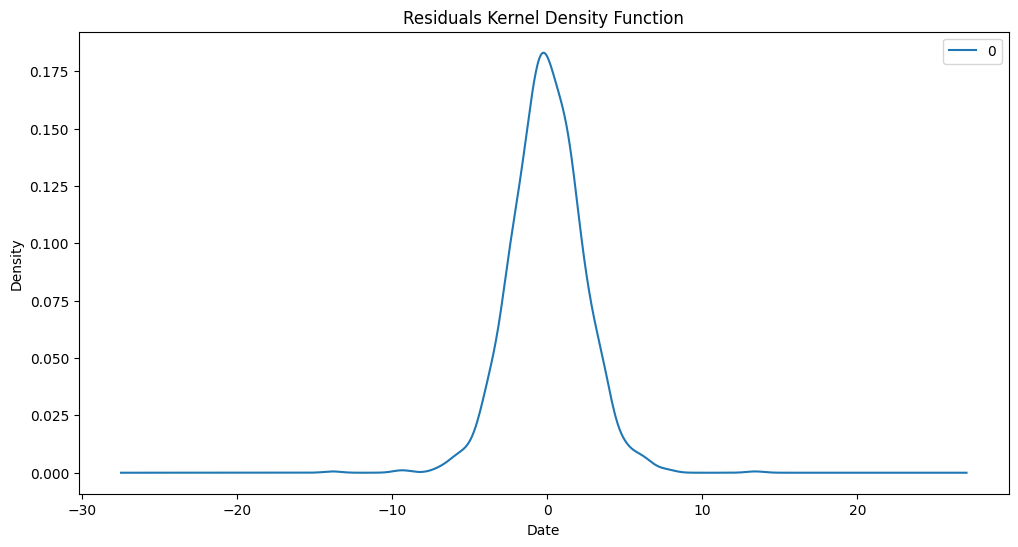

In [8]:
resid_plots1 = plt.figure(figsize=(12, 6))
plt.plot(resid)
plt.title("Residuals", figure=resid_plots1)
plt.xlabel("Date", figure=resid_plots1)
plt.ylabel("Residuals", figure=resid_plots1)
plt.show()

resid_plots2 = plt.figure(figsize=(12, 6))
ax = resid_plots2.add_subplot(111)
plt.title("Residuals Kernel Density Function", figure=resid_plots2)
plt.xlabel("Date", figure=resid_plots2)
resid.plot(kind='kde', ax=ax)

<Axes: title={'center': 'Rolling Variance of Residuals'}, xlabel='date'>

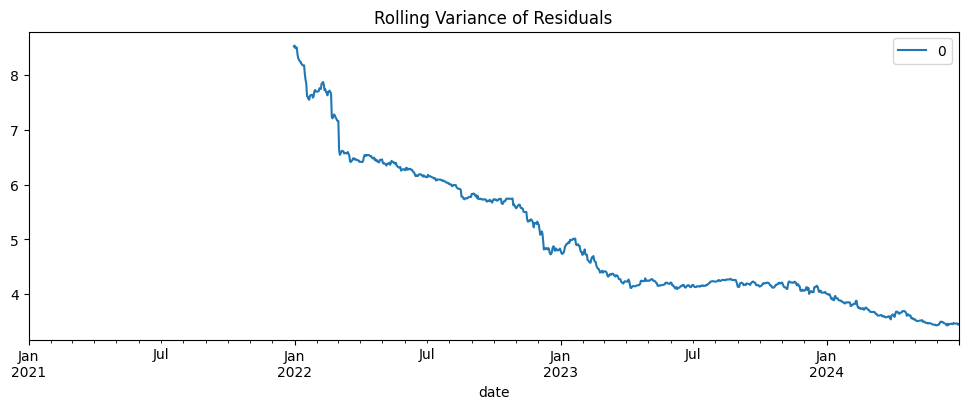

In [9]:
rolling_var = resid.rolling(window=365).var()
rolling_var.plot(figsize=(12,4), title='Rolling Variance of Residuals')

In [10]:
def shapiro_normality_test(data):
    p_value = shapiro(data)[1]
    if p_value >= 0.05:
        print("Data follows normal distribution: X~N"+ str((np.round(np.mean(data),3), np.round(np.std(data),3))))
        print("Shapiro test p_value={}".format(np.round(p_value,3)))
    else:
        print("Data failed shapiro normality test with p_value={}".format(p_value))

shapiro_normality_test(resid)

from statsmodels.stats.stattools import jarque_bera

def jarque_bera_normality_test(data):
    jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(data)

    # Convert to Python floats for clean formatting
    jb_stat = float(jb_stat)
    jb_pvalue = float(jb_pvalue)
    skew = float(skew)
    kurtosis = float(kurtosis)

    if jb_pvalue >= 0.05:
        print("Data follows a normal distribution: X ~ N({}, {})".format(
            np.round(np.mean(data), 3), np.round(np.std(data), 3)))
        print("Jarque-Bera test p-value = {:.4f}".format(jb_pvalue))
        print("Skewness = {:.4f}, Kurtosis = {:.4f}".format(skew, kurtosis))
    else:
        print("Data failed the Jarque-Bera normality test.")
        print("Jarque-Bera test p-value = {:.4f}".format(jb_pvalue))

        
jarque_bera_normality_test(resid)
        

Data failed shapiro normality test with p_value=1.1768721552840589e-09
Data failed the Jarque-Bera normality test.
Jarque-Bera test p-value = 0.0000


# HDD Contracts


In [11]:
print(results.mle_retvals)

{'fopt': 2.235365225763235, 'gopt': array([-1.13617517e-02, -1.84026305e-04,  5.44138024e-04, -3.14413162e-04,
       -6.33222363e-06,  2.98053671e-04,  1.49671386e-06, -7.28644256e-05]), 'fcalls': 540, 'warnflag': 1, 'converged': False, 'iterations': 50}


In [12]:
test_data = pd.read_csv('/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Data/test_data_HDD.csv')
test_data['date'] = pd.to_datetime(test_data['date'])
test_data.set_index('date', inplace=True)
test_data = test_data.resample('D').asfreq().fillna(method='ffill')

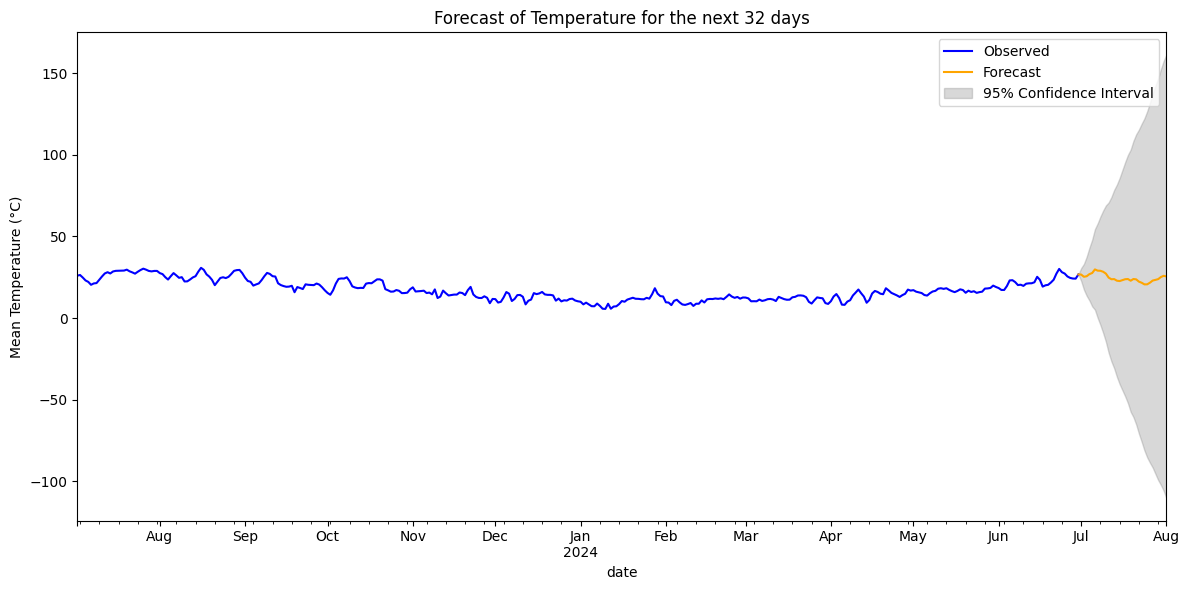

In [19]:
# === 1. Forecast setup ===
forecast_length = len(test_data)

# Generate future dates
future_dates = pd.date_range(
    start=train_data.index[-1] + pd.Timedelta(days=1),
    periods=forecast_length,
    freq='D'
)

# === 2. Generate forecast in differenced space ===
forecast_obj = results.get_forecast(steps=forecast_length)
forecast_diff = forecast_obj.predicted_mean

# === 3. Re-integrate forecast to levels ===
last_train_point = train_data['mean'].iloc[-1]
forecast_level = forecast_diff.cumsum() + last_train_point

# === 4. Re-integrate confidence intervals ===
conf_int_diff = forecast_obj.conf_int()  # Still in differenced space
conf_int_cumsum = conf_int_diff.cumsum()

conf_int_level = pd.DataFrame(index=future_dates)
conf_int_level["lower"] = conf_int_cumsum.iloc[:, 0] + last_train_point
conf_int_level["upper"] = conf_int_cumsum.iloc[:, 1] + last_train_point

# === 5. Build forecast DataFrame ===
future_df = pd.DataFrame(index=future_dates)
future_df["forecast"] = forecast_level.values

# Add last training point for plot continuity
future_df.loc[train_data.index[-1]] = last_train_point
conf_int_level.loc[train_data.index[-1]] = [last_train_point, last_train_point]

# Sort to make sure plotting is clean
future_df = future_df.sort_index()
conf_int_level = conf_int_level.sort_index()

# === 6. Plot forecast and confidence intervals ===
plot_length = 365  # Days of training data to show

plt.figure(figsize=(12, 6))
plt.title(f'Forecast of Temperature for the next {forecast_length} days')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (°C)')

# Plot observed and forecast
train_data['mean'][-plot_length:].plot(label='Observed', color='blue')
future_df["forecast"].plot(label='Forecast', color='orange')

# Plot confidence intervals
plt.fill_between(
    conf_int_level.index,
    conf_int_level["lower"],
    conf_int_level["upper"],
    color='gray',
    alpha=0.3,
    label='95% Confidence Interval'
)

plt.legend()
plt.tight_layout()
plt.show()

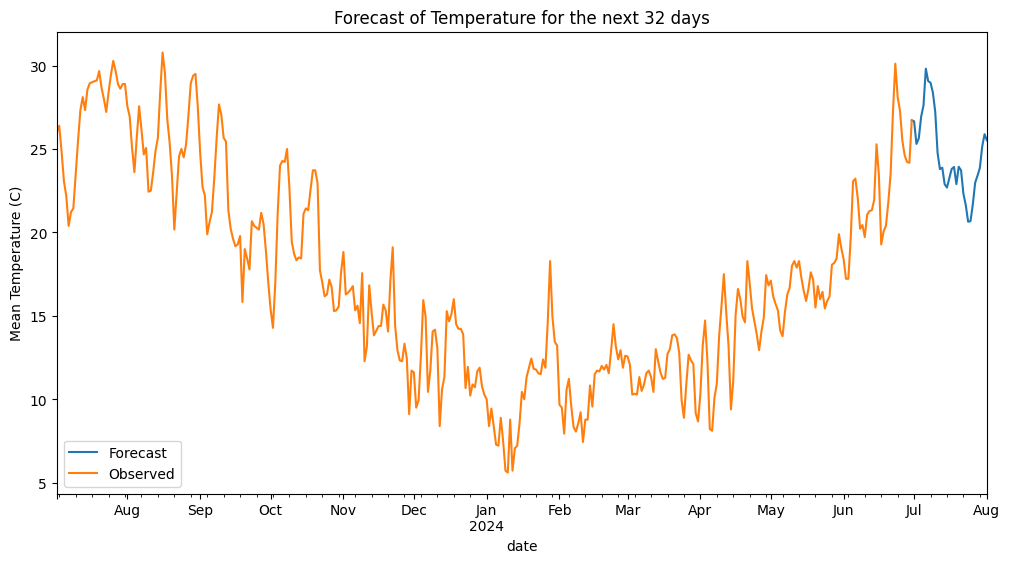

In [14]:
# Define forecast horizon
forecast_length = len(test_data)

# Forecast starts 1 day after the last training date
future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), 
                             periods=forecast_length, freq='D')

# Generate forecast (in first-difference space)
forecast_obj = results.get_forecast(steps=forecast_length)
forecast_diff = forecast_obj.predicted_mean  # These are differences

# Reconstruct original scale by cumulatively summing the differences
last_train_point = train_data['mean'].iloc[-1]
forecast_level = forecast_diff.cumsum() + last_train_point

# Build forecast DataFrame with re-integrated predicted values
future_df = pd.DataFrame(index=future_dates)
future_df["forecast"] = forecast_level.values

# Optional: Add last training point for continuity in plotting
future_df.loc[train_data.index[-1]] = last_train_point
future_df = future_df.sort_index()

# Plotting
plot_length = 365
plt.figure(figsize=(12, 6))
plt.title(f'Forecast of Temperature for the next {forecast_length} days')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (C)')

# Plot forecast and observed data
future_df["forecast"].plot(label='Forecast')
train_data['mean'][-plot_length:].plot(label='Observed')

# Add confidence interval
#conf_int.index = future_dates  # Align CI index
'''plt.fill_between(future_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2)'''

plt.legend()
plt.show()

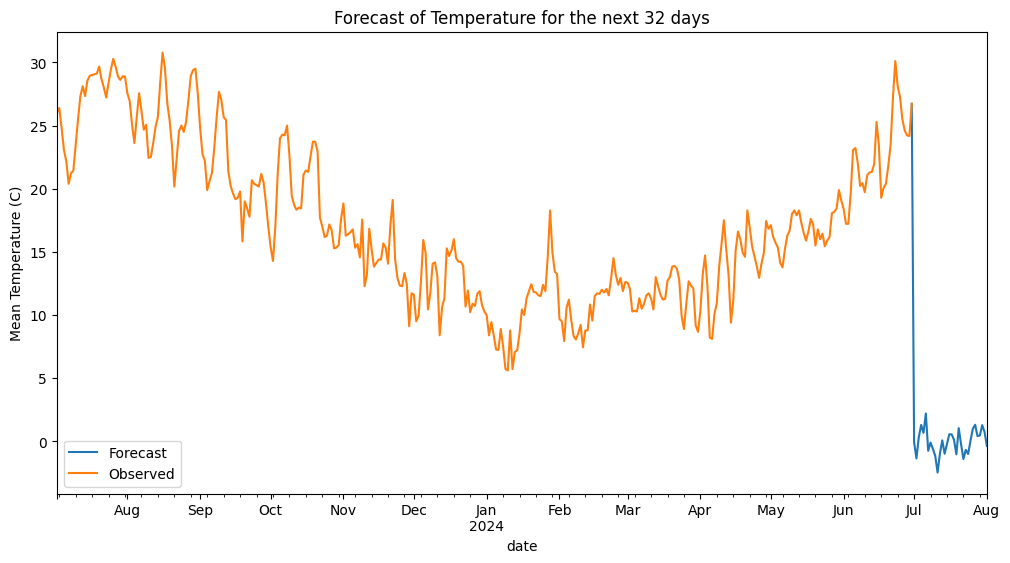

In [13]:
# Define forecast horizon
forecast_length = len(test_data)

# Forecast starts 1 day after the last training date
future_dates = pd.date_range(start=train_data.index[-1] + dt.timedelta(days=1), 
                             periods=forecast_length, freq='D')

# Generate forecast
forecast_obj = results.get_forecast(steps=forecast_length)
forecast_mean = forecast_obj.predicted_mean
#conf_int = forecast_obj.conf_int()

# Build forecast DataFrame with predicted values
future_df = pd.DataFrame(index=future_dates)
future_df["forecast"] = forecast_mean.values

# ✅ Add last training point to future_df to ensure continuous line
last_train_point = train_data['mean'].iloc[-1]
last_train_date = train_data.index[-1]
future_df.loc[last_train_date] = [last_train_point]
future_df = future_df.sort_index()  # Ensure correct order

# Plotting
plot_length = 365
plt.figure(figsize=(12, 6))
plt.title(f'Forecast of Temperature for the next {forecast_length} days')
plt.xlabel('Date')
plt.ylabel('Mean Temperature (C)')

# Plot forecast and observed data
future_df["forecast"].plot(label='Forecast')
train_data['mean'][-plot_length:].plot(label='Observed')

# Add confidence interval
#conf_int.index = future_dates  # Align CI index
'''plt.fill_between(future_dates, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='gray', alpha=0.2)'''

plt.legend()
plt.show()


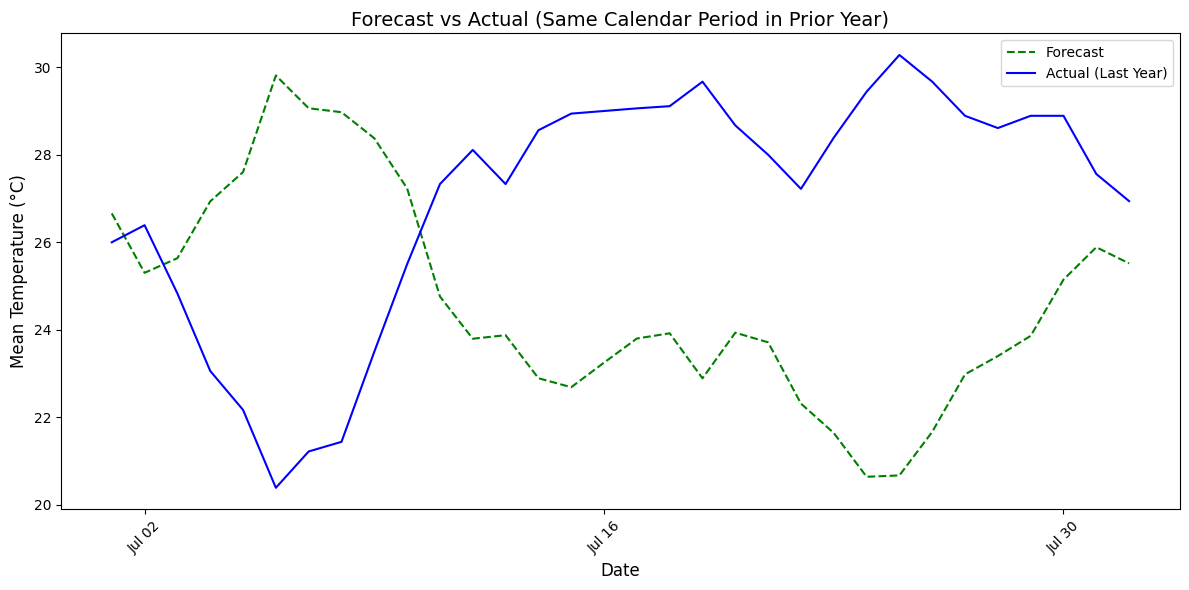

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Reset to default Matplotlib style (no Seaborn grid)
plt.style.use('default')

# Drop the extra initial row used to connect the lines
forecast = future_df["forecast"].iloc[1:]  # skip the first (training) point
forecast_index = forecast.index

# Get actual data from same seasonal window a year earlier
actual_last_year = train_data['mean'][-365:-365 + len(forecast)].copy()
actual_last_year.index = forecast_index  # align dates for plotting

# Plot
plt.figure(figsize=(12, 6))
plt.plot(forecast.index, forecast, label="Forecast", color="green", linestyle="--")
plt.plot(actual_last_year.index, actual_last_year, label="Actual (Last Year)", color="blue")

# Formatting
plt.title("Forecast vs Actual (Same Calendar Period in Prior Year)", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Temperature (°C)", fontsize=12)
plt.legend()
plt.xticks(rotation=45)

# Better x-axis formatting
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

plt.tight_layout()
plt.show()


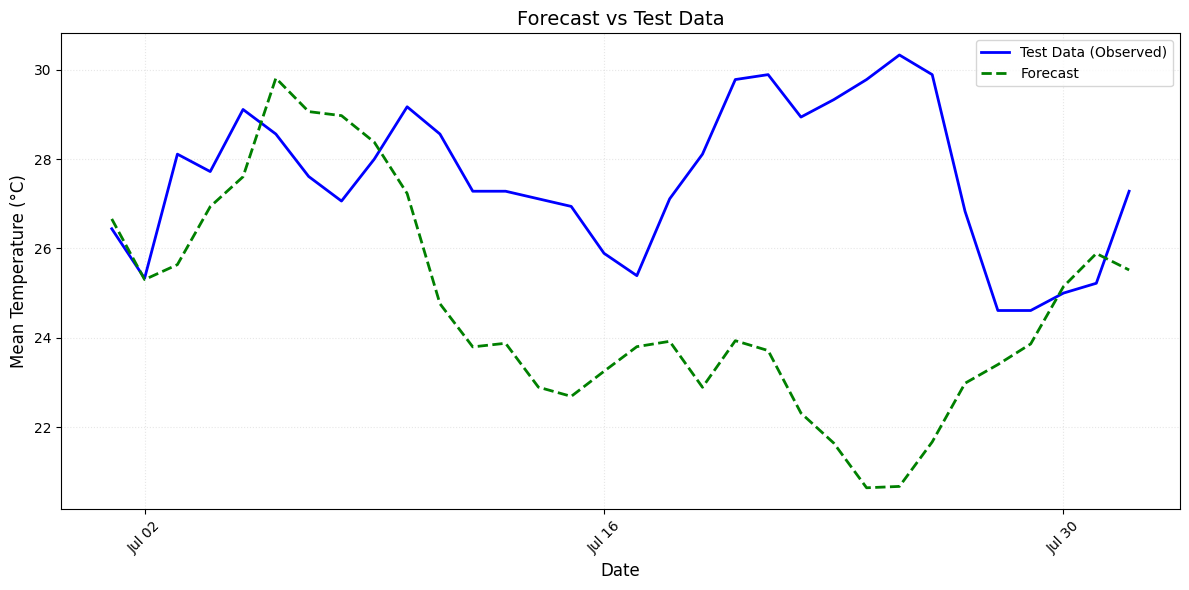

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure forecast (test) has the same index as test_data
test = future_df["forecast"].iloc[1:]  # remove connector point
test.index = test_data[:forecast_length].index

# Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data['mean'][:forecast_length], label="Test Data (Observed)", color="blue", linewidth=2)
plt.plot(test, label="Forecast", color="green", linestyle="--", linewidth=2)

# Title and labels
plt.title("Forecast vs Test Data", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Mean Temperature (°C)", fontsize=12)

# X-axis formatting
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))

# Grid and legend
plt.grid(True, which='major', linestyle=':', alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()



In [17]:
#Calculate the RMSE and MAE and MASE
def calculate_errors(test, forecast):
    rmse = np.sqrt(np.mean((test - forecast) ** 2))
    mae = np.mean(np.abs(test - forecast))
    mase = mae / np.mean(np.abs(np.diff(test)))
    
    return rmse, mae, mase
rmse, mae, mase = calculate_errors(test_data['mean'][:31], test)
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MASE: {mase}")

RMSE: 4.318761718330041
MAE: 3.3455054465610057
MASE: 3.7477656234813352


In [18]:
# Save the forecasts as a CSV file
future_df.to_csv('/Users/gianiranzetti/Github/Minerva---Weather-Derivatives/Forecasts/SARIMA_Forecast.csv', index=True)